In [1]:
import tensorflow as tf
import numpy as np
import keras
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import keras.datasets as mnist
import os



2024-11-07 22:42:05.512320: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 22:42:05.512404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 22:42:05.513832: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 22:42:05.522687: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-07 22:42:06.798696: W tensorflow/compiler/tf2

In [2]:
#Image Data Details
IMAGE_SIZE = 28
IMAGE_PATCH_SIZE = 14
NUM_PATCHES = int((IMAGE_SIZE / IMAGE_PATCH_SIZE) ** 2)
NUM_CLASSES = 10
NUM_LAYERS = 1
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, NUM_LAYERS)

#Transformer settings
PROJECTION_HIDDEN_DIMENSIONS = int(98) #98 hidden dimensions when linear transforming for first time
NUM_SELFATTENTION_HEADS = 4 #each multihead has 4 self attention layers
TRANSFORMER_UNITS = [
    PROJECTION_HIDDEN_DIMENSIONS * 2,
    PROJECTION_HIDDEN_DIMENSIONS,
]  # Size of the transformer layers used for skip connecionts
TRANSFORMER_LAYERS = 16 #actual times transformer layers repeat
MLP_FINALLAYERS = [2028, 1024]

In [3]:
#load data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
#convert to float
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
#expand for said 1 layer dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(x_train.shape)
print(y_train.shape)
print(y_train)

y_train = tf.convert_to_tensor(np.array(y_train), dtype="int32")
y_test = tf.convert_to_tensor(np.array(y_test), dtype="int32")
print(x_test.shape)
print(y_test.shape)
print(y_train)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(60000,)
[5 0 4 ... 5 6 8]


2024-11-07 22:42:10.158998: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-07 22:42:10.233315: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-07 22:42:10.233567: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

(10000, 28, 28, 1)
(10000,)
tf.Tensor([5 0 4 ... 5 6 8], shape=(60000,), dtype=int32)


L355
2024-11-07 22:42:12.249888: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-07 22:42:12.250135: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-07 22:42:12.250303: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#

In [4]:
#Hyper Params
learning_rate = 0.001
weight_decay = 0.000001
batch_size = 2000
num_epochs = 30

In [23]:
#Data Augmentation Layer
dataAugmentation = keras.Sequential([
    keras.layers.Normalization(),
    keras.layers.RandomRotation(.1),
    keras.layers.RandomZoom(width_factor=.1, height_factor=.1)
],
name="dataAug")
dataAugmentation.layers[0].adapt(x_train)
#plt.imshow(dataAugmentation(x_train[0]))
#print(x_train.shape)
#x = dataAugmentation(x_train[:2000])
#x = tf.expand_dims(x, axis=-1)
#x = tf.reshape(x, shape=(2000, 28, 28, 1))
print(x.shape)
#y = CreatePatches(IMAGE_PATCH_SIZE)(x)
#PositionalEmbeddingsAndEncoder(NUM_PATCHES, PROJECTION_HIDDEN_DIMENSIONS)(y)

(2000, 28, 28, 1)


In [6]:
#positional embeddings and creating patch sizes. Also final layer
def endPortionMLP(inputted, hiddenUnitsArray, dropoutRate):
    for units in hiddenUnitsArray:
        x = keras.layers.Dense(units, activation=tf.nn.gelu)(inputted)
        x = keras.layers.Dropout(dropoutRate)(x)
    return x

class CreatePatches(keras.layers.Layer):
    def __init__(self, patchSize):
        super().__init__()
        self.patchSize = patchSize
    
    def call(self, inputImages):
        batchSize = tf.shape(inputImages)[0] #gets the first column of input
        patches = tf.image.extract_patches(
            images = inputImages,
            sizes=[1, self.patchSize, self.patchSize, 1],
            strides=[1, self.patchSize, self.patchSize, 1],
            rates=[1, 1, 1, 1],
            padding="VALID" #this means no padding
        )
        #patchDimensions = patches.shape()[-1] #gets the shape minus number of patches in batch
        patches = tf.reshape(patches, [batchSize, -1, self.patchSize * self.patchSize* 1]) #shape now [batches, patch#, patchdims]
        return patches
    
class PositionalEmbeddingsAndEncoder(keras.layers.Layer):
    def __init__(self, numberPatches, projectionDimension):
        super().__init__()
        self.numPatches = numberPatches
        self.projection = keras.layers.Dense(units=projectionDimension)
        self.positionalEmbedding = keras.layers.Embedding(
            input_dim=numberPatches, output_dim=projectionDimension
        )
    
    def call(self, inputtedPatches):
        positions = tf.expand_dims(tf.range(start=0, limit=self.numPatches, delta=1), axis=0)
        #positions = tf.range(start=0, limit=self.numPatches, delta=1) #increment stuff
        embeddings = self.positionalEmbedding(positions) + self.projection(inputtedPatches)
        return embeddings
        #return self.positionalEmbedding(positions)
        #return self.projection(inputtedPatches)



In [24]:
#create the vision transformer
def VisionTransformer():
    #input layer
    inputs = keras.layers.Input(shape=x_train[0].shape)

    #get the augmented data
    augmentedData = dataAugmentation(inputs)
    
    #reshape bc tensorflow truncates for some reason
    #augmentedData = tf.expand_dims(augmentedData, axis=-1)
    #apparently just works now thanks tf
    
    #get the individual patches
    patches = CreatePatches(IMAGE_PATCH_SIZE)(augmentedData) #init data then call

    encoded_patches = PositionalEmbeddingsAndEncoder(NUM_PATCHES, PROJECTION_HIDDEN_DIMENSIONS)(patches)

    #multihead attention blocks of encoder
    for i in range(TRANSFORMER_LAYERS):
        x1 = keras.layers.Normalization()(encoded_patches)

        attentionOutput = keras.layers.MultiHeadAttention(num_heads=NUM_SELFATTENTION_HEADS, key_dim=PROJECTION_HIDDEN_DIMENSIONS, dropout=0.12)(x1, x1)
        
        x2 = keras.layers.Add()([attentionOutput, encoded_patches]) #skip connection

        x3 = keras.layers.LayerNormalization(epsilon=1e-6)(x2)

        x3 = endPortionMLP(x3, hiddenUnitsArray=TRANSFORMER_UNITS, dropoutRate=0.12)

        encoded_patches = keras.layers.Add()([x3, x2]) #skip connection

    #[batchsize, info] tensor
    endingPortion = keras.layers.Normalization()(encoded_patches)
    endingPortion = keras.layers.Flatten()(endingPortion)
    endingPortion = keras.layers.Dropout(0.5)(endingPortion)

    #final mlp
    endingPortion = endPortionMLP(endingPortion, hiddenUnitsArray=TRANSFORMER_UNITS, dropoutRate=0.5)

    logits = keras.layers.Dense(NUM_CLASSES)(endingPortion)
    logits = keras.layers.Softmax()(logits)

    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [25]:
def runModel(model):
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay)
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy'), keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])
    
    checkpoint_path = "training_4/cp.ckpt.weights.h5"
    #checkpoint_dir = os.path.dirname(checkpoint_path)
    network_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor="accuracy",
                                                 mode = 'max',
                                                 save_best_only=True
                                                )
    history = model.fit(x=x_train,y=y_train,batch_size=batch_size,epochs=num_epochs,validation_split=0.1,callbacks=[network_callback])

    model.load_weights(checkpoint_path)
    accuracy = model.evaluate(x=x_test, y=y_test)
    print("testing set accuracy")
    print(accuracy)
    return history

In [30]:
checkpoint_path = "training_4/cp.ckpt.weights.h5"
model = VisionTransformer()
model.load_weights(checkpoint_path)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy'), keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")])
model.evaluate(x_test, y_test)
#model.summary()


313/313 [==============================] - 8s 19ms/step - loss: 0.0633 - accuracy: 0.9818 - top-5-accuracy: 0.9994


[0.06329003721475601, 0.9818000197410583, 0.9994000196456909]

In [ ]:
#delete later for debugging
print(x_train[0].shape)

Epoch 1/30


2024-11-07 22:57:13.766075: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd633bfb940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-07 22:57:13.766151: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro P5000, Compute Capability 6.1
2024-11-07 22:57:13.798127: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-07 22:57:14.684427: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1731020234.779732      99 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 [==============================] - 39s 290ms/step - loss: 4.3991 - accuracy: 0.3074 - top-5-accuracy: 0.7518 - val_loss: 0.9711 - val_accuracy: 0.6620 - val_top-5-accuracy: 0.9607
Epoch 2/30
27/27 [==============================] - 6s 233ms/step - loss: 1.5806 - accuracy: 0.5051 - top-5-accuracy: 0.8818 - val_loss: 0.6374 - val_accuracy: 0.7920 - val_top-5-accuracy: 0.9850
Epoch 3/30
27/27 [==============================] - 6s 235ms/step - loss: 1.2145 - accuracy: 0.6311 - top-5-accuracy: 0.9231 - val_loss: 0.4785 - val_accuracy: 0.8592 - val_top-5-accuracy: 0.9828
Epoch 4/30
27/27 [==============================] - 6s 237ms/step - loss: 0.8650 - accuracy: 0.7439 - top-5-accuracy: 0.9594 - val_loss: 0.2524 - val_accuracy: 0.9397 - val_top-5-accuracy: 0.9935
Epoch 5/30
27/27 [==============================] - 6s 236ms/step - loss: 0.5747 - accuracy: 0.8324 - top-5-accuracy: 0.9780 - val_loss: 0.2199 - val_accuracy: 0.9458 - val_top-5-accuracy: 0.9948
Epoch 6/30
27/27 [============

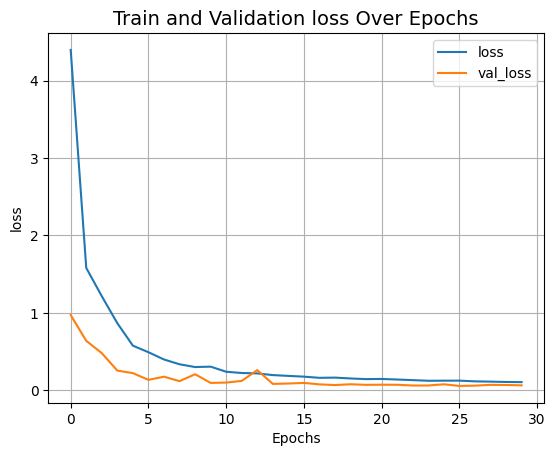

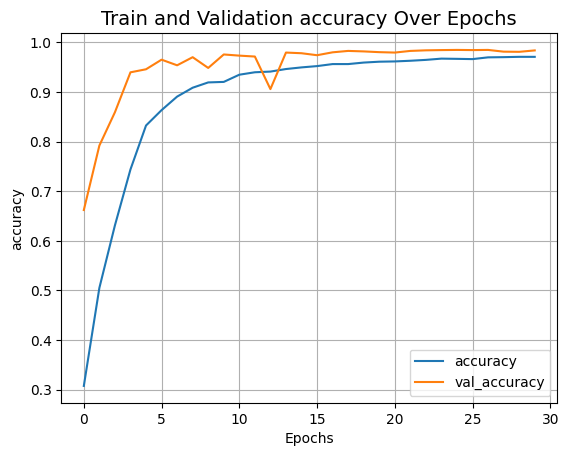

In [28]:
vit_classifier = VisionTransformer()
history = runModel(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=10)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("accuracy")